<a href="https://colab.research.google.com/github/AshAswin/evidential_mcdo_adf_gp/blob/main/GP_Regression_toydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
!pip install gpflow
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow.utilities import print_summary
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
import gpflow as gpf
np.random.seed(0)
tf.random.set_seed(0)
from abc import ABC, abstractmethod
from dataclasses import dataclass
import torch

In [2]:
#fn1
mu = 0
sigma = 0.08
#train_data generated from two intervals in the total range
train_range = np.linspace(-3, 3, 100).reshape(-1,1)
test_range = np.linspace(-5,5,100).reshape(-1,1)
function = lambda x:np.sin(3*x)/(3*x)


In [3]:
#fn2
# mu = 0
# sigma = 0.025
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-4, -1, 50).reshape(-1,1)
# range2 = np.linspace(1, 4, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-4,4,200).reshape(-1,1)
# function = lambda x:0.1*x**3


In [4]:
#fn3
# mu = 0
# sigma = 0.04
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-6, -2, 50).reshape(-1,1)
# range2 = np.linspace(2, 6, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-6,6,200).reshape(-1,1)
# function = lambda x:-(1+x)*np.sin(1.2*x)

In [5]:
class Data():
  def __init__(self, x, func, noise={'mu':0,'sigma':1}):
    self.x = x
    self.y_gt = func(self.x)
    self.epsilon = np.random.normal(noise['mu'],noise['sigma'],np.shape(x))
    self.y = self.y_gt + self.epsilon

def plot_results(train_data,test_data, prediction, aleatoric, epistemic,\
                 limits,v_span, legend_loc, fn_samples, title='', filename='fn'):
  #Obtain Standard Deviation  
  aleatoric = np.sqrt(aleatoric)
  epistemic = np.sqrt(epistemic)
  # plot and show learning process
  fig, ax = plt.subplots(figsize=(15,10))
  plt.cla()

  aleatoric = aleatoric[:,0]
  epistemic = epistemic[:,0]#.squeeze()
  prediction = prediction[:,0]

  ax.fill_between(test_data.x.squeeze(), prediction + 2*aleatoric,\
                  prediction - 2*aleatoric, color='peachpuff',\
                  alpha=0.9,label='aleatoric')
  ax.fill_between(test_data.x.squeeze(), prediction +2*epistemic,\
                  prediction-2*epistemic, color='blue',alpha=0.2,\
                  label='epistemic')

  ax.set_title(title, fontsize=35)
  ax.set_xlabel('input', fontsize=24)
  ax.set_ylabel('output', fontsize=24)
  # ax.set_xlim(x.min,x.max)
  ax.set_xlim(limits['x'])
  ax.set_ylim(limits['y'])

  for limits in v_span:
    ax.axvspan(limits[0], limits[1], alpha=0.25, color='lightgreen',label='OOD')
  
  ax.scatter(train_data.x.squeeze(), train_data.y.squeeze(), color = "green",\
             label='train_inputs')
  ax.plot(test_data.x.squeeze(), prediction, 'g-', lw=3, label='prediction',\
          color='blue')
  ax.plot(test_data.x.squeeze(),test_data.y_gt.squeeze(),lw=3,\
          label='ground truth',color='black',linestyle='--')
  plt.legend(loc=legend_loc, prop={'size':20})
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid()
  plt.savefig(filename,format='pdf',dpi=400)

In [6]:
#metrics
def log_likelihood(y_pred, y_true, sigma):
    y_true = torch.Tensor(y_true)
    y_pred= torch.Tensor(y_pred)
    sigma = torch.Tensor(sigma)
    
    dist = torch.distributions.normal.Normal(loc=y_pred, scale=sigma)
    ll = torch.mean(dist.log_prob(y_true))
    ll = np.asscalar(ll.numpy())
    print("NLL = {}".format(-ll))
    return ll


def compute_rmse(predictions, real_values):
    assert np.all(predictions.shape == real_values.shape)
    mse = np.mean(np.square(predictions - real_values))
    rmse = np.sqrt(mse)
    print("RMSE = {}".format(rmse))
    return rmse

def explained_variance_1d(ypred,y):
    """
    Var[ypred - y] / var[y].
    https://www.quora.com/What-is-the-meaning-proportion-of-variance-explained-in-linear-regression
    """
    assert y.ndim == 1 and ypred.ndim == 1
    vary = np.var(y)
    return np.nan if vary==0 else 1 - np.var(y-ypred)/vary


def compute_explained_variance(predictions, real_values):
    """
    Computes the explained variance of prediction for each
    steering and the average of them
    """
    assert np.all(predictions.shape == real_values.shape)
    ex_variance = explained_variance_1d(predictions, real_values)
    print("EVA = {}".format(ex_variance))
    return ex_variance

In [7]:
train_data = Data(train_range, function,noise={'mu':mu, 'sigma':sigma})
test_data = Data(test_range, function,noise={'mu':mu, 'sigma':sigma})

In [8]:
#Homoscedastic GP params initialization
homo_kernel = gpflow.kernels.Matern52()

homo_gp_mdl = gpflow.models.GPR(data=(train_data.x,train_data.y),\
                                kernel=homo_kernel, mean_function=None)
homo_gp_mdl.likelihood.variance.assign(0.01)
homo_gp_mdl.kernel.lengthscales.assign(0.3)

homo_opt = gpflow.optimizers.Scipy()
opt_logs = homo_opt.minimize(homo_gp_mdl.training_loss,\
                    homo_gp_mdl.trainable_variables, options=dict(maxiter=100))

NLL = -0.8249399662017822
RMSE = 0.06993534919335319
EVA = 0.9491593382638375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':


0.9491593382638375

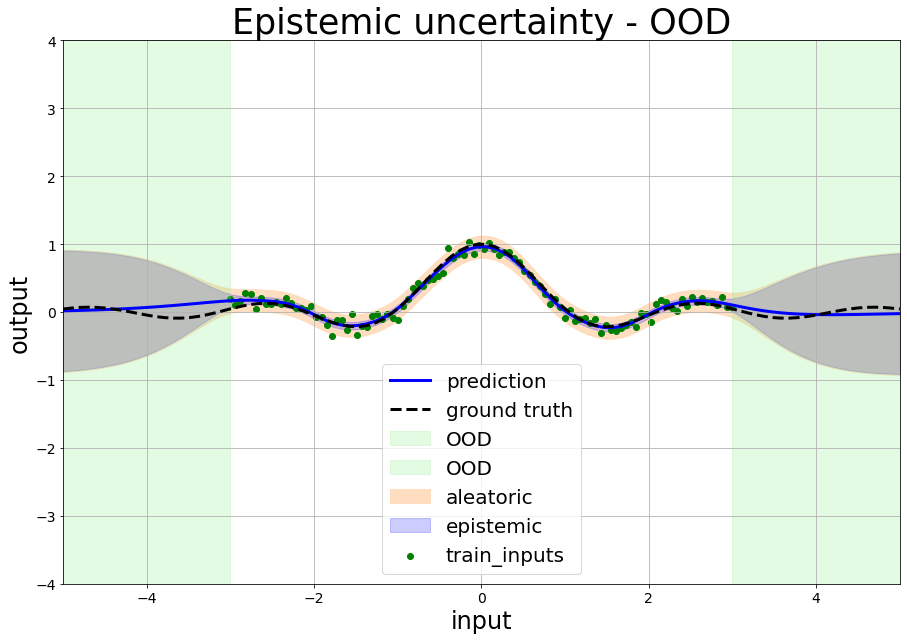

In [9]:
#Homoscedastic GP inference
mean, epistemic= homo_gp_mdl.predict_f(test_data.x)
_ , aleatoric = homo_gp_mdl.predict_y(test_data.x)

function_samples = homo_gp_mdl.predict_f_samples(test_data.x,10)
#plot outputs


plot_results(train_data,test_data, mean,\
             aleatoric, epistemic,\
              limits={"x":(-5,5),"y":(-4,4)},v_span=[(-5,-3),(3,5)],
             fn_samples=None, legend_loc='lower center',
             title='Epistemic uncertainty - OOD',filename='epi_ood.pdf')

predictive_uncertainty = epistemic + aleatoric
mean = np.asarray(mean)
predictive_uncertainty = np.asarray(predictive_uncertainty)

log_likelihood(mean.squeeze(), test_data.y_gt.squeeze(),\
               np.sqrt(predictive_uncertainty).squeeze())
compute_rmse(mean.squeeze(),test_data.y_gt.squeeze())
compute_explained_variance(mean.squeeze(), test_data.y_gt.squeeze())

In [10]:
#Heteroscedastic GP
#Initializations
hetero_gp_likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)
print(f"Likelihood's expected latent_dim: {hetero_gp_likelihood.latent_dim}")
hetero_gp_kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)
#Inducing points need to be initialized for using Stochastic Variational Gaussian Process Model
M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(train_data.x.min(), train_data.x.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)
hetero_gp_mdl = gpf.models.SVGP(
    kernel=hetero_gp_kernel ,
    likelihood=hetero_gp_likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=hetero_gp_likelihood.latent_dim,
)
hetero_gp_mdl

Likelihood's expected latent_dim: 2


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3....
SVGP.q_mu,Parameter,Identity,,True,"(20, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 20, 20)",float64,"[[[1., 0., 0...."


In [11]:
#Build Optimizers
data = (train_data.x, train_data.y)

loss_fn = hetero_gp_mdl.training_loss_closure(data)

gpf.utilities.set_trainable(hetero_gp_mdl.q_mu, False)
gpf.utilities.set_trainable(hetero_gp_mdl.q_sqrt, False)

variational_vars = [(hetero_gp_mdl.q_mu, hetero_gp_mdl.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = hetero_gp_mdl.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [12]:
#optimization loop
epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = hetero_gp_mdl.predict_y(train_data.x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
hetero_gp_mdl

Instructions for updating:
Use fn_output_signature instead
Epoch 20 - Loss: -19.3408
Epoch 40 - Loss: -73.5746
Epoch 60 - Loss: -75.7131
Epoch 80 - Loss: -76.1678
Epoch 100 - Loss: -76.4932


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7017845085503436
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0125813438004827
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2168659137822828
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.285536429916873
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3.01458505...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-3.55094499...
SVGP.q_mu,Parameter,Identity,,False,"(20, 2)",float64,"[[1.76234410e-01, -1.71280969e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 20, 20)",float64,"[[[6.18297869e-02, 0.00000000e+00, 0.00000000e+00..."


### Key take-aways from using heteroscedastic GPs in GPFlow

1. The predict_f method yields means and model variances of both f1 and f2. The mean_f1 corresponds to the prediction , while mean_f2 after exponentiation corresponds to sqrt(noise_variances of my inputs).
2. variances of variance_f1, variance_f2 correspond to the model variances of f1 and f2 respectively.
3. predict_y yields mean_y which is equal to mean_f1. However, variance_f2 is composed by variances corresponding to the hybrid likelihood(f1 and f2).
Based on this understanding and my need, I have used mean_f1 to be prediction, variance_f1 as epistemic variance(model variance) and exp(mean_f2) as noise variance/aleatoric variance of my inputs. I have obtained predictive variance/uncertainty by summing of both model and noise variances.



NLL = -0.5137421488761902
RMSE = 0.08893623585474246
EVA = 0.9176812664613223


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':


0.9176812664613223

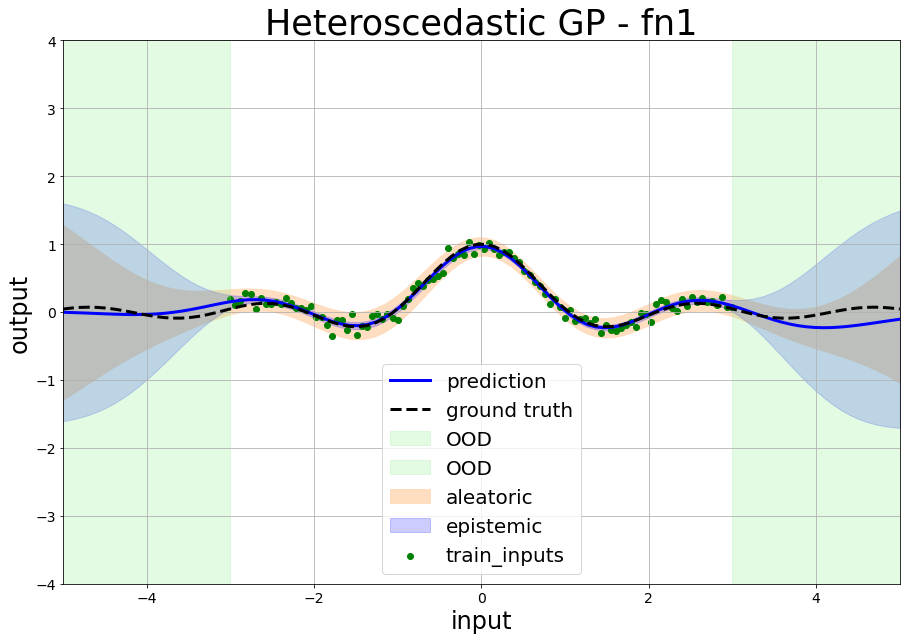

In [13]:
#heteroscedastic GP inference
mean, variance = hetero_gp_mdl.predict_f(test_data.x)

prediction = mean[:,0]
aleatoric = (np.exp(mean[:,1]))**2
epistemic = variance[:,0]




function_samples = hetero_gp_mdl.predict_f_samples(test_data.x,10)

aleatoric = np.reshape(aleatoric,(-1,1))
epistemic = np.reshape(epistemic,(-1,1))

plot_results(train_data,test_data, mean,\
             aleatoric, epistemic,\
              limits={"x":(-5,5),"y":(-4,4)},v_span=[(-5,-3),(3,5)],
             fn_samples=None, legend_loc='lower center',
             title='Heteroscedastic GP - fn1',filename='hetero_fn1.pdf')

predictive_uncertainty = epistemic + aleatoric
mean = np.asarray(prediction)

log_likelihood(mean.squeeze(), test_data.y_gt.squeeze(),\
               np.sqrt(predictive_uncertainty))
compute_rmse(mean.squeeze(),test_data.y_gt.squeeze())
compute_explained_variance(mean.squeeze(), test_data.y_gt.squeeze())
